<a href="https://colab.research.google.com/github/larrygaw/review-vetting-tiktok-hackathon/blob/main/tiktok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pandas numpy tqdm pyarrow fastparquet scikit-learn sentence-transformers emoji
!pip -q install nltk textblob datasketch scipy transformers accelerate -q

import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import json, pandas as pd
import numpy as np
from tqdm import tqdm
import os
import re, json, math
import nltk
import joblib

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from scipy import sparse
from scipy.sparse import hstack, save_npz, csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.multiclass import OneVsRestClassifier
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Change file names and categories

In [ ]:
reviews_infile = "/content/drive/MyDrive/data/raw/reviews-colorado.json"
meta_infile = "/content/drive/MyDrive/data/raw/metadata-colorado.json"
outfile = "/content/drive/MyDrive/data/processed/reviews_full_features.parquet"

# Create the directory if it doesn't exist
output_dir = os.path.dirname(outfile)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ---- Step 1: Load metadata into dict (keyed by gmap_id) ----
meta_keep = ["gmap_id", "name", "description", "category", "avg_rating"]

meta_dict = {}
with open(meta_infile, 'rt', encoding='utf8') as f:
    for line in tqdm(f, desc="Loading metadata"):
        obj = json.loads(line)
        gmap_id = obj.get("gmap_id")
        if gmap_id:
            meta_dict[gmap_id] = {k: obj.get(k) for k in meta_keep}

print("Metadata businesses loaded:", len(meta_dict))

# ---- Step 2: Stream reviews and merge with metadata ----
keep, max_rows = [], 65000
with open(reviews_infile, 'rt', encoding='utf8') as f:
    for line in tqdm(f, desc="Reading reviews"):
        if len(keep) >= max_rows:
            break

        obj = json.loads(line)
        gmap_id = obj.get("gmap_id")

        # Only keep if we also have metadata
        if obj.get("text") and gmap_id in meta_dict:
            merged = {
                "user_id": obj.get("user_id"),
                "rating": obj.get("rating"),
                "text": obj.get("text"),
                "pics": obj.get("pics"),
                "resp": obj.get("resp"),
                "gmap_id": gmap_id,
                **meta_dict[gmap_id]   # unpack selected metadata
            }
            keep.append(merged)

# ---- Step 3: Save ----
df = pd.DataFrame(keep)
df.to_parquet(outfile, index=False)
print("Final merged dataset size:", len(df))
print("Total rows:", len(df))
print("Unique businesses (gmap_id):", df['gmap_id'].nunique())

Loading metadata: 106829it [00:06, 17743.76it/s]


Metadata businesses loaded: 106245


Reading reviews: 85704it [00:04, 17597.93it/s]


Final merged dataset size: 65000
Total rows: 65000
Unique businesses (gmap_id): 3078


In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/data/processed/reviews_full_features.parquet")
df.head()
df.info()
df['text'].str.len().describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      65000 non-null  object 
 1   rating       65000 non-null  int64  
 2   text         65000 non-null  object 
 3   pics         1830 non-null   object 
 4   resp         22904 non-null  object 
 5   gmap_id      65000 non-null  object 
 6   name         65000 non-null  object 
 7   description  2799 non-null   object 
 8   category     64946 non-null  object 
 9   avg_rating   65000 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 5.0+ MB


,text
count,65000.000000
mean,266.007431
std,308.976148
min,1.000000
25%,83.000000
50%,181.000000
75%,336.000000
max,4094.000000


In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/data/processed/reviews_full_features.parquet")

# Common TLDs + shorteners
TLDs = r"com|net|org|io|co|biz|info|edu|gov|me|ly|gl|is|gg|xyz|sh|su|in|fm|ws|cc|cm|ru|cn|tv"

url_pattern = re.compile(
    rf"\b(?:http[s]?://|www\.|[a-zA-Z0-9\-]+\.)(?:{TLDs})\b(?:/[^\s]*)?",
    re.IGNORECASE
)

# Create a new column with all URLs found
df['extracted_URLs'] = df['text'].apply(lambda x: url_pattern.findall(str(x)))

# Number of reviews containing at least one URL
print("Reviews with URLs:", df['extracted_URLs'].apply(len).gt(0).sum())

# Display first 10 reviews with extracted URLs
df[df['extracted_URLs'].apply(len) > 0][['text','extracted_URLs']].head(10)
all_urls = [url for sublist in df['extracted_URLs'] for url in sublist]
unique_urls = set(all_urls)
print("Total unique URLs found:", len(unique_urls))
print(list(unique_urls))

Reviews with URLs: 27
Total unique URLs found: 21
['uce.gov', 'gmail.com', 'davistent.com', 'Coloradoevents.org', 'Dimebags.com', 'DimeBags.com', 'wm.com', 'health.com', 'uhaul.com', 'AMCPainting.com', 'well.in', 'Ezprints.com', 'hotels.com', 'OurWeddingPhotoVideo.com', 'bomb.com', 'patioenclosures.com', 'TransientCraft.com', 'CalabreseGreenhouse.com', 'keep.me', 'HHS.gov', 'alexforsythe.com']


In [ ]:
# Load the parquet file
df = pd.read_parquet("/content/drive/MyDrive/data/processed/reviews_full_features.parquet")

print("Before cleaning:", len(df))

# Keep only rows where text is not null and has at least 10 characters
df = df[df['text'].notna()]
df = df[df['text'].str.strip().str.len() > 10]

# Drop duplicate reviews
df = df.drop_duplicates(subset=["user_id", "text"])

print("After removing empty and duplicate texts:", len(df))

def clean_text(text):
    text = str(text)
    # replace emojis
    text = emoji.replace_emoji(text, replace='<EMOJI>')
    # mask URLs, emails, phones
    # common TLDs including shorteners
    TLDs = r"com|net|org|io|co|biz|info|edu|gov|me|ly|gl|is|gg|xyz|sh|su|in|fm|ws|cc|cm|ru|cn|tv"
    url_pattern = re.compile(
        rf"\b(?:http[s]?://|www\.|[a-zA-Z0-9\-]+\.)(?:{TLDs})\b(?:/[^\s]*)?",
        re.IGNORECASE
    )
    text = url_pattern.sub('<URL>', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '<EMAIL>', text)
    text = re.sub(r'\b(\+?\d[\d\s\-\(\)]{7,})\b', '<PHONE>', text)
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Save cleaned version
processed_path = "/content/drive/MyDrive/data/processed/reviews_clean.parquet"
df.to_parquet(processed_path, index=False)

# Inspect
print("After cleaning & normalization:", len(df))
df.info()
df.sample(5)

Before cleaning: 65000
After removing empty and duplicate texts: 52047
After cleaning & normalization: 52047
<class 'pandas.core.frame.DataFrame'>
Index: 52047 entries, 0 to 64999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      52047 non-null  object 
 1   rating       52047 non-null  int64  
 2   text         52047 non-null  object 
 3   pics         1521 non-null   object 
 4   resp         18584 non-null  object 
 5   gmap_id      52047 non-null  object 
 6   name         52047 non-null  object 
 7   description  2166 non-null   object 
 8   category     52009 non-null  object 
 9   avg_rating   52047 non-null  float64
 10  clean_text   52047 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.8+ MB


,user_id,rating,text,pics,resp,gmap_id,name,description,category,avg_rating,clean_text
39906,103326999533207265524,5,This is the second time using Sunrize and Mr. ...,None,None,0x876c8045b5ee2bfb:0x3bed26ce42958fda,"Sunrize Home Inspection Services,LLC",None,"[Home inspector, Service establishment]",4.5,This is the second time using Sunrize and Mr. ...
29020,116708775335090332951,5,These guys are truly the best. Very easy to ge...,None,{'text': 'Thank you Bret. Your review is so k...,0x876c7f1ddba65467:0xf66b743a077882e4,Brick Repair Denver,None,"[Masonry contractor, Bricklayer, Building rest...",4.9,These guys are truly the best. Very easy to ge...
54028,118035378071292655692,5,This store has the perfect mix of items. The w...,None,"{'text': 'Thank you, Jennie! We enjoyed meetin...",0x876c91a2a90c8be1:0x5f0ea5588c8216d0,Niche & Co,None,"[Furniture store, Gift shop, Home goods store,...",5.0,This store has the perfect mix of items. The w...
64584,114154209434416078016,5,Both Dr. Karen and Michele (owners) have taken...,None,{'text': 'Thank you Lindsey! We are so happy t...,0x876c83bc34c23a97:0xd55e9e11d8937454,Altitude Animal Hospital,None,[Veterinarian],4.9,Both Dr. Karen and Michele (owners) have taken...
27489,113838608492387607797,1,(Translated by Google) SLooooooooooooooooooooo...,None,None,0x876c7931aa21e72b:0xe6d5d02990fed53b,Kaiser Permanente Skyline Medical Offices - De...,None,[Medical Center],4.1,(Translated by Google) SLooooooooooooooooooooo...


Number of reviews: 52047

Sample rows:


,user_id,rating,text,pics,resp,gmap_id,name,description,category,avg_rating,clean_text
46023,108398455622857098774,1,"Looked online, said open. Driving, all signs p...",None,None,0x876c67151bcba287:0xb09a28c639e4044b,DEN - Mt. Elbert Shuttle Lot,None,[Parking lot],1.0,"Looked online, said open. Driving, all signs p..."
16591,104981972365499386980,5,Jack is very professional and easy to work wit...,None,{'text': 'Thank you for the wonderful feedback...,0x876c8825e16ac0f1:0xd9c2de35d1a02402,Jack Sughrue: Allstate Insurance,None,"[Insurance agency, Auto insurance agency, Home...",4.3,Jack is very professional and easy to work wit...
23243,100321203415214092084,5,They did a great job of adding in a back up ca...,None,None,0x876bec28dd56a3ed:0xfcf8d5c3dd4eef57,Absolutely Creative Customs,None,"[Car stereo store, Car alarm supplier]",4.8,They did a great job of adding in a back up ca...
30239,111405404887819950174,5,"Next to dealer, redrocks were the only company...",None,None,0x876b877bbe76f8cf:0xeedf335978b16687,Red Rocks Locksmith Arvada,None,[Locksmith],4.9,"Next to dealer, redrocks were the only company..."
23921,105226915280404731139,5,Joined for the powerlifting equipment and stay...,None,None,0x87694be311c2b315:0x6e496e9b21e06fd1,Elevate Barbell,None,[Gym],5.0,Joined for the powerlifting equipment and stay...


/tmp/ipython-input-689499768.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="viridis")


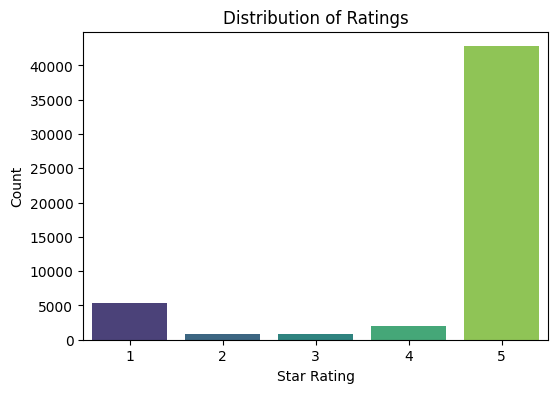

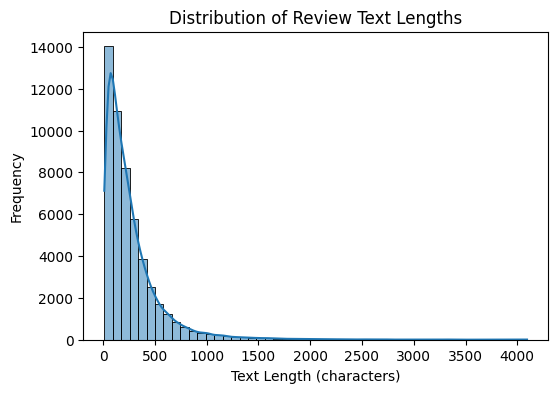

Average text length: 269.8281361077488

Examples of Very Positive Reviews:


,text
6416,Loved this place. Very nice stadium!
28882,I have been a patent for over 10 years. Have a...
28817,First and foremost I would like to thank Leona...



Examples of Very Negative Reviews:


,text
33751,I called and left several voice mails with All...
1921,Stupid place for a 6 year old
52026,I went on here and read the reviews before I e...


Reviews with URL: 23
Reviews with EMAIL: 0
Reviews with PHONE: 38


In [ ]:
# Load your cleaned data
df = pd.read_parquet("/content/drive/MyDrive/data/processed/reviews_clean.parquet")

# Quick look
print("Number of reviews:", len(df))
print("\nSample rows:")
display(df.sample(5))

# --- 1. Ratings Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df, palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

# --- 2. Review Length Distribution ---
df["text_length"] = df["text"].str.len()

plt.figure(figsize=(6,4))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Review Text Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

print("Average text length:", df["text_length"].mean())

# --- 3. Example Reviews ---
print("\nExamples of Very Positive Reviews:")
display(df[df["rating"]==5].sample(3)[["text"]])

print("\nExamples of Very Negative Reviews:")
display(df[df["rating"]==1].sample(3)[["text"]])

# --- 4. Percentage of URLs, emails, phone numbers ---
df['has_URL'] = df['clean_text'].str.contains('<URL>')
df['has_EMAIL'] = df['clean_text'].str.contains('<EMAIL>')
df['has_PHONE'] = df['clean_text'].str.contains('<PHONE>')

print("Reviews with URL:", df['has_URL'].sum())
print("Reviews with EMAIL:", df['has_EMAIL'].sum())
print("Reviews with PHONE:", df['has_PHONE'].sum())

In [ ]:
# Load your cleaned dataset
df = pd.read_parquet("/content/drive/MyDrive/data/processed/reviews_clean.parquet")

# -----------------------------
# Step 1: Create stratification column (by text length)
# -----------------------------
# Short: 10–50 chars, Medium: 51–150, Long: 151–500, Very Long: 501+
df['strata_len'] = pd.cut(
    df['clean_text'].str.len(),
    bins=[10, 50, 150, 500, 10000],
    labels=['short', 'medium', 'long', 'very_long'],
    include_lowest=True
)

# -----------------------------
# Step 2: Sample dev set (500 rows) stratified by strata
# -----------------------------
dev_set_size = 500
# Stratified proportional sampling
strata_counts = df['strata_len'].value_counts()
dev_samples = []

for i, stratum in enumerate(strata_counts.index):
    n = max(1, int(dev_set_size * strata_counts[stratum] / len(df)))
    # If this is the last stratum, adjust to reach exact dev_set_size
    if i == len(strata_counts) - 1:
        n = dev_set_size - sum(len(s) for s in dev_samples)
    dev_samples.append(df[df['strata_len'] == stratum].sample(n=n, random_state=42))

dev_df = pd.concat(dev_samples).reset_index(drop=True)
print("Dev set size:", len(dev_df))  # should be exactly 500
print(dev_df['strata_len'].value_counts())

# -----------------------------
# Step 3: Save dev set for labeling
# -----------------------------
dev_set_path = "/content/drive/MyDrive/data/processed/dev_set.parquet"
dev_df.to_parquet(dev_set_path, index=False)
dev_df.to_csv(dev_set_path.replace('.parquet', '_labeled.csv'), index=False)

# Inspect sample
dev_df.sample(5)

Dev set size: 500
strata_len
long         222
medium       144
short         67
very_long     67
Name: count, dtype: int64


,user_id,rating,text,pics,resp,gmap_id,name,description,category,avg_rating,clean_text,strata_len
373,102131297628235686752,5,Glad this place exists... needed to stop 🤗,None,None,0x876c3649fe9b03bd:0xa32392123e3ca8ba,Roggen Farmers Elevator Association,None,[Alternative fuel station],3.8,Glad this place exists... needed to stop <EMOJI>,short
151,107212023218224737648,5,She is the best and most affordable massage th...,None,None,0x876c7dd5dd08d2b3:0x6da6ddb055110ee3,Tranquil Kiwi Massage,Relaxed locale offering therapeutic massage tr...,[Massage therapist],4.9,She is the best and most affordable massage th...,long
316,110262508771054997074,5,"Great food and cocktails, excellent service, c...",None,None,0x876ea3089adec9d1:0xf87ee82517dd0e38,Capri Greeley,None,[Restaurant],4.5,"Great food and cocktails, excellent service, c...",medium
421,100428935080549881430,5,My kids had so much fun here!,None,None,0x871535300bfff3f3:0xec69d9d20f8b5119,Buena Vista Skate Park,None,"[Skateboard park, Recreation]",4.5,My kids had so much fun here!,short
79,106911211844811361808,5,"Being a new resident of Colorado, I was nervou...",None,{'text': 'Thank you for sharing your experienc...,0x87694ae0545f3a8f:0x1b0708f84defdbc5,UCHealth Gastroenterology Clinic - Fort Collins,None,"[Gastroenterologist, Medical clinic]",3.8,"Being a new resident of Colorado, I was nervou...",long


In [ ]:
from sklearn.model_selection import train_test_split

# Exclude dev set
remaining_df = df.drop(dev_df.index)

# Split 80/20 (training / validation)
train_df, valid_df = train_test_split(
    remaining_df,
    test_size=0.2,
    random_state=42,
    stratify=None  # Optional: stratify by rating or URL presence
)

for df_part in [train_df, valid_df]:
    if "text" in df_part.columns:
        df_part.drop(columns=["text"], inplace=True)
print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))

# Save
train_path = "/content/drive/MyDrive/data/processed/train.parquet"
valid_path = "/content/drive/MyDrive/data/processed/valid.parquet"
train_df.to_parquet(train_path, index=False)
valid_df.to_parquet(valid_path, index=False)


Training set size: 41237
Validation set size: 10310


In [ ]:
# Load training and validation sets
train_df = pd.read_parquet("/content/drive/MyDrive/data/processed/train.parquet")
valid_df = pd.read_parquet("/content/drive/MyDrive/data/processed/valid.parquet")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)


Train shape: (41237, 11)
Valid shape: (10310, 11)


In [ ]:
# Checks for URLs, emails, phone, emoji, character length, word length,
# caps ratio and punctuation ratio of text

PROMO_WORDS = re.compile(
    r"\b(voucher|coupon|promo\s?code|% ?off|dm\b|whatsapp|telegram|wechat|subscribe|click|call\s+now)\b",
    re.IGNORECASE
)
RANT_NV_VISIT = re.compile(
    r"\b(never (been|went|visited)|i haven'?t (been|gone)|heard (that|it)|people say|i saw online|looks (bad|dirty)|seems (bad|overpriced)|probably (awful|bad)|all (restaurants|fast food) (are|is) (terrible|bad)|friend told me|everyone says)\b",
    re.IGNORECASE
)

# Exception words after "never been"
EXCEPTIONS = {"so", "this", "that", "happier", "angrier", "tempted", "disappointed", "treated", "wrong", "told", "given"}

def is_non_visit(review: str) -> bool:
    match = RANT_NV_VISIT.search(review)
    if match:
        # Check if the match was "never been"
        if match.group().lower().startswith("never been"):
            # Grab the next word after the phrase
            after = review[match.end():].strip().split()[:1]
            if after and after[0].lower() in EXCEPTIONS:
                return False  # Exception → not a non-visit rant
        return True
    return False



def add_rule_flags(df, text_col="clean_text"):
    s = df[text_col].fillna("")

    # Direct checks for substituted tokens
    df["f_url"] = s.str.contains("<URL>", regex=False)
    df["f_email"] = s.str.contains("<EMAIL>", regex=False)
    df["f_emoji"] = s.str.contains("<EMOJI>", regex=False)
    df["f_phone"] = s.str.contains("<PHONE>", regex=False)
    df["f_promo"] = s.apply(lambda x: bool(PROMO_WORDS.search(x)))

    # Rant phrases
    df["f_rant_nv_phrase"] = s.apply(is_non_visit)

    # Length / ratio features
    df["char_len"] = s.str.len()
    df["word_len"] = s.str.split().str.len()
    df["caps_ratio"] = s.apply(lambda x: (sum(c.isupper() for c in x) / max(1, len(x))))
    df["punc_ratio"] = s.apply(lambda x: (sum(c in ".,!?;:" for c in x) / max(1, len(x))))

    # Counts
    df["url_count"] = s.str.count("<URL>")
    df["email_count"] = s.str.count("<EMAIL>")
    df["emoji_count"] = s.str.count("<EMOJI>")
    df["phone_count"] = s.str.count("<PHONE>")
    df["promo_count"] = s.apply(lambda x: len(PROMO_WORDS.findall(x)))

    return df

# Apply
train_df = add_rule_flags(train_df)
valid_df = add_rule_flags(valid_df)

In [ ]:
train_df.head()
print(train_df.columns)


Index(['user_id', 'rating', 'pics', 'resp', 'gmap_id', 'name', 'description',
       'category', 'avg_rating', 'clean_text', 'strata_len', 'f_url',
       'f_email', 'f_emoji', 'f_phone', 'f_promo', 'f_rant_nv_phrase',
       'char_len', 'word_len', 'caps_ratio', 'punc_ratio', 'url_count',
       'email_count', 'emoji_count', 'phone_count', 'promo_count'],
      dtype='object')


In [ ]:
# Adds user_review_count and user_avg_rating to df
def add_user_history(df):
    cnt = df.groupby("user_id")["gmap_id"].transform("count")
    df["user_review_count"] = cnt
    # user’s average given rating (within your dataset slice)
    user_avg = df.groupby("user_id")["rating"].transform("mean")
    df["user_avg_rating"] = user_avg
    return df

train_df = add_user_history(train_df)
valid_df = add_user_history(valid_df)


In [ ]:
# Count users with more than 1 review in train
train_user_counts = train_df.groupby("user_id")["gmap_id"].count()
train_multi_review_users = (train_user_counts > 1).sum()

# Count users with more than 1 review in valid
valid_user_counts = valid_df.groupby("user_id")["gmap_id"].count()
valid_multi_review_users = (valid_user_counts > 1).sum()

print("Users with >1 review in TRAIN:", train_multi_review_users)
print("Users with >1 review in VALID:", valid_multi_review_users)

Users with >1 review in TRAIN: 1015
Users with >1 review in VALID: 111


In [ ]:
# Outpuuts reviews with promo matches, likely to be advertisements

# For train set
promo_count_train = train_df["f_promo"].sum()
print("Number of promo reviews in TRAIN:", promo_count_train)

# For validation set
promo_count_valid = valid_df["f_promo"].sum()
print("Number of promo reviews in VALID:", promo_count_valid)

# Ensure Pandas displays full column content
pd.set_option("display.max_colwidth", None)

def get_violated_words(text):
    return re.findall(PROMO_WORDS, text)

# TRAIN set
train_df["promo_matches"] = train_df["clean_text"].apply(get_violated_words)

# VALID set
valid_df["promo_matches"] = valid_df["clean_text"].apply(get_violated_words)

# Display flagged reviews with violated words
for i, row in train_df[train_df["f_promo"]].iterrows():
    print(f"User: {row['user_id']}, Rating: {row['rating']}")
    print(row["clean_text"])
    print("Violated words:", row["promo_matches"])
    print("-" * 80)


Number of promo reviews in TRAIN: 63
Number of promo reviews in VALID: 7
User: 107052193931013267242, Rating: 4
The only thing I found odd was when the rep told me that the paperwork I brought in is usually brought in by folks that don't have hearing aids.  It was a coupon for a fresh turkey for the holidays or $1,500. off a new set.  Disappointing.
Violated words: ['coupon']
--------------------------------------------------------------------------------
User: 115874524245828437805, Rating: 2
Two star rating for customer service today. The cashier forgot to scan my coupon, which was $10 off a purchase of $40 or more.

No biggie. She told me the customer service desk would help.

I went to customer service to explain my problem. The first words out of the mouth of the customer service rep were “unfortunately I can’t do anything to help you”.

Yes, you can. I am holding my receipt fresh off the printer from less than a minute ago. The sign above your head reads ‘customer service’. I hav

In [ ]:
# Outputs reviews that likely never visited the place, using regex matching

def get_non_visit_matches(text):
    matches = []
    for match in re.finditer(RANT_NV_VISIT, text):
        phrase = match.group()
        # Exception check for "never been"
        if phrase.lower().startswith("never been"):
            after = text[match.end():].strip().split()[:1]
            if after and after[0].lower() in EXCEPTIONS:
                continue  # Skip this match
        matches.append(phrase)
    return matches

# TRAIN set
train_df["rant_matches"] = train_df["clean_text"].apply(get_non_visit_matches)

for i, row in train_df[train_df["f_rant_nv_phrase"]].iterrows():
    print(f"User: {row['user_id']}, Rating: {row['rating']}")
    print(row["clean_text"])
    print("Violated words:", row["rant_matches"])
    print("-" * 80)

User: 112745774717790602436, Rating: 5
I haven't been to, nor paid for services. I did run into an employee at Microcenter, who in passing conversation pointed me in the direction for a solution that is going to save me upgrading a drive. So thanks for that!
Violated words: ["I haven't been"]
--------------------------------------------------------------------------------
User: 115125650018315875582, Rating: 5
Icouldnt give high enough praise as a doctor and as a wonderful and caring person and doc! I absolutely love my Doctor, Dr. Courtney Crance, she never ceases to amaze me with her knowledge and determination to help her patients to the best of her ability and the upmost care. She has an amazing bedside manner and is genuine, very knowledgeable and I couldn't even imagine having to have gone through this last year without her, after my other amazing doctor changed fields of practice and I didn't qualify for his new place of work. I am more impressed more and more by Courtney with e

In [ ]:
# Displays information of reviews that are likely to be rants or promo

# For train_df
if "rant_matches" in train_df.columns:
    train_df = train_df.drop(columns=["rant_matches"])

# For valid_df
if "rant_matches" in valid_df.columns:
    valid_df = valid_df.drop(columns=["rant_matches"])

# For train_df
if "promo_matches" in train_df.columns:
    train_df = train_df.drop(columns=["promo_matches"])

# For valid_df
if "promo_matches" in valid_df.columns:
    valid_df = valid_df.drop(columns=["promo_matches"])

train_df.head()

,user_id,rating,pics,resp,gmap_id,name,description,category,avg_rating,clean_text,...,word_len,caps_ratio,punc_ratio,url_count,email_count,emoji_count,phone_count,promo_count,user_review_count,user_avg_rating
0,111409042788238323845,5,None,None,0x876bef6f09142799:0xdeae9aa279e41fb,"Axe Whooping - Axe Throwing Boulder, CO",None,[Recreation center],5.0,"Paul was wonderful! I was terrible but he was so, so helpful!",...,12,0.032787,0.049180,0,0,0,0,0,1,5.0
1,107150670242046709860,4,None,None,0x876b657046282ac1:0x4890a281b68381cb,William Westall Memorial Info Plaque,None,[Museum],4.2,Cool history,...,2,0.083333,0.000000,0,0,0,0,0,1,4.0
2,110493854823776694005,5,None,"{'text': 'Dear D'Arcy, thank you so much for taking the time to leave this excellent review. We really appreciate you. Pleased let us know if there is anything we can do for you in the future. Thank you', 'time': 1620419519169.0}",0x876c81dc5c8a61eb:0xd33ffa88a3c1cdba,Priority Junk Removal,None,[Garbage collection service],5.0,"At the initial phone contact I was given the range of cost to haul away our stuff. After receiving a picture from us David gave us a more than reasonable price.Same day pickup,right on time friendly and professional.We are planning on future work on our homeand will definitely use their service again!! Thank you",...,54,0.022293,0.019108,0,0,0,0,0,1,5.0
3,114074824983584919116,5,None,"{'text': 'Hi Jan, thank you so much for your kind words. It was truly a pleasure helping you through this transaction! I'm thrilled it was exceptional for you.', 'time': 1576525041174.0}",0x876eb34e7a146ed9:0x7ded4090236c8d8,"Ben Emslie, Real Estate Broker",None,"[Real estate agency, Commercial real estate agency, Real estate agents]",5.0,"What a pleasure it was to work with Ben Emslie on the sale of my home! I couldn't have chosen a better agent. He was personable, knowledgeable about my neighborhood and so professional. His experience made the whole process so easy. He seemed genuinely excited about my home and did an exceptional job of marketing it, with the result that my home was under contract at full price after less than a week. And he continued his support and assistance after closing. I was lucky to find him. He's truly one of the best!",...,94,0.019120,0.019120,0,0,0,0,0,1,5.0
4,116815765833213993613,5,None,"{'text': 'It was nice to meet you today, Adrian! I'm glad we were able to save the groceries!', 'time': 1583025763426.0}",0x876b8a864e88cd6d:0x9119f08b19caef5b,Lockstar,None,"[Locksmith, Service establishment]",5.0,I had a very pleasant and professional interaction with Brett from Lockstar. He came over in good time over the weekend to help get me back into my house for a reasonable price after I inadvertantly locked myself out. I really appreciated his approach of reviewing all the options available to him and finding the least destructive and easiest method. Thank you!,...,62,0.019337,0.011050,0,0,0,0,0,1,5.0


In [ ]:
# Checks for positive or negative sentiment of review

sia = SentimentIntensityAnalyzer()
def vader_score(text):
    try:
        return sia.polarity_scores(text or "")["compound"]
    except Exception:
        return 0.0

train_df["sentiment"] = train_df["clean_text"].map(vader_score)
valid_df["sentiment"] = valid_df["clean_text"].map(vader_score)
print(train_df[["clean_text", "sentiment"]].head(10))


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    clean_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Paul 

In [ ]:
# Checks for similarity between place name/category/description, and review text

# Function to create place text from metadata
def place_text(df):
    name = df.get("name", "")
    cat = df.get("category", "")
    desc = df.get("description", "")
    # Concatenate and fill NaNs
    return (name.fillna("") + " " + cat.fillna("") + " " + desc.fillna("")).str.strip()

train_df["place_text"] = place_text(train_df)
valid_df["place_text"] = place_text(valid_df)

# Load model on GPU
sb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device='cpu')

# Function to embed in batches
def embed_in_batches(texts, batch_size=512):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_emb = sb_model.encode(texts[i:i+batch_size], normalize_embeddings=True)
        embeddings.append(batch_emb)
    return np.vstack(embeddings)

# Ensure all texts are strings
train_texts = train_df["clean_text"].fillna("").astype(str).tolist()
train_places = train_df["place_text"].fillna("").astype(str).tolist()
valid_texts = valid_df["clean_text"].fillna("").astype(str).tolist()
valid_places = valid_df["place_text"].fillna("").astype(str).tolist()

# Then embed in batches
train_review_emb = embed_in_batches(train_texts)
train_place_emb  = embed_in_batches(train_places)
valid_review_emb = embed_in_batches(valid_texts)
valid_place_emb  = embed_in_batches(valid_places)

# suppose train_review_emb, valid_review_emb are NumPy arrays (shape [N, d])
# reduce dim so we can add to sparse matrix (e.g. d->128)
svd = TruncatedSVD(n_components=128, random_state=42)
train_emb_reduced = svd.fit_transform(train_review_emb)
valid_emb_reduced = svd.transform(valid_review_emb)

# scale dense emb features
scaler_emb = StandardScaler()
train_emb_scaled = scaler_emb.fit_transform(train_emb_reduced)
valid_emb_scaled = scaler_emb.transform(valid_emb_reduced)

# Save embeddings
np.save("train_emb_scaled.npy", train_emb_scaled)
np.save("valid_emb_scaled.npy", valid_emb_scaled)

# Cosine similarity: dot product since embeddings are normalized
train_df["rel_sim"] = np.sum(train_review_emb * train_place_emb, axis=1)
valid_df["rel_sim"] = np.sum(valid_review_emb * valid_place_emb, axis=1)

# Inspect
print("Train similarities:", train_df["rel_sim"].head())
print("Validation similarities:", valid_df["rel_sim"].head())

KeyboardInterrupt: 

In [ ]:
# Checks across all reviews for reviews that are highly similar to each other

from datasketch import MinHash, MinHashLSH

def text2shingles(s, k=5):
    s = (s or "").lower()
    return { s[i:i+k] for i in range(max(0, len(s)-k+1)) }

def build_lsh_index(texts, threshold=0.8, num_perm=64):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    mhs = []
    for i, t in enumerate(texts):
        mh = MinHash(num_perm=num_perm)
        for sh in text2shingles(t):
            mh.update(sh.encode('utf8'))
        lsh.insert(f"id{i}", mh)
        mhs.append(mh)
    return lsh, mhs

def dup_cluster_sizes(texts, lsh, mhs):
    sizes = []
    for i, mh in enumerate(mhs):
        sizes.append(len(lsh.query(mh)))
    return np.array(sizes)

# Build only on train (can be heavy), map to valid by approximate scan (or skip for valid)
lsh, mhs = build_lsh_index(train_df["clean_text"].fillna("").tolist(), threshold=0.85, num_perm=64)
train_df["dup_cluster_size"] = dup_cluster_sizes(train_df["clean_text"].fillna("").tolist(), lsh, mhs)
# For valid, a simple proxy: nearest neighbors in train LSH (optional)
valid_df["dup_cluster_size"] = 1  # safe default if you skip cross-set querying


In [ ]:
# Outputs reviews that are highly similar to each other, with the repeated texts

# Only flag near-duplicates if they are long enough and cluster size is high
MIN_CHAR_LEN = 5
MIN_DUP_CLUSTER = 2

IGNORE_PHRASES = ["great service", "great customer service", "great place", "excellent service", "great people", "love this place",
                  "good service", "great experience", "helpful", "professional", "friendly staff", "great staff"]

# Mark suspicious duplicates
train_df["dup_suspicious"] = (
    (train_df["char_len"] >= MIN_CHAR_LEN) &
    (train_df["dup_cluster_size"] >= MIN_DUP_CLUSTER)
)

pattern = "|".join(IGNORE_PHRASES)
train_df.loc[train_df["clean_text"].str.lower().str.contains(pattern), "dup_suspicious"] = False

# Inspect suspicious duplicates
dup_suspicious = train_df[train_df["dup_suspicious"]].sort_values("dup_cluster_size", ascending=False)
pd.set_option("display.max_colwidth", None)
print(dup_suspicious.head(20))

                     user_id  rating  pics  \
12608  100622997784628155375       5  None   
4247   109575461589224716437       5  None   
5591   115100969839632410246       5  None   
6676   102941995055486771086       5  None   
10447  100343348082723461756       5  None   
28718  114316568216328730172       5  None   
23386  108434702425275192649       5  None   
39250  111985840970654487430       5  None   
37596  111027877378029367995       5  None   
35333  109928971969791964349       5  None   
38909  111881279515370667497       5  None   
25211  105800536661897977195       5  None   
28874  112591346278198571360       5  None   
16572  103033843687360892573       5  None   
17228  112047112932905813996       5  None   
23008  117700153994654454353       5  None   
886    110588199700440807454       5  None   
2891   118138906955833911732       5  None   
14432  110513702514430878911       5  None   
14424  103056335020756940647       3  None   

                                 

In [ ]:
train_df = pd.read_parquet("/content/drive/MyDrive/data/features/train_features.parquet")
valid_df = pd.read_parquet("/content/drive/MyDrive/data/features/valid_features.parquet")

print(list(train_df.columns))   # as Python list
train_df = train_df.drop(columns=["gmap_id", "name", "description", "avg_rating",
                 "strata_len", "f_email", "resp", "user_id", "email_count", "place_text"])

print(list(train_df.columns))   # as Python list
print(train_df.head())

['user_id', 'rating', 'pics', 'resp', 'gmap_id', 'name', 'description', 'category', 'avg_rating', 'clean_text', 'strata_len', 'f_url', 'f_email', 'f_emoji', 'f_phone', 'f_promo', 'f_rant_nv_phrase', 'char_len', 'word_len', 'caps_ratio', 'punc_ratio', 'url_count', 'email_count', 'emoji_count', 'phone_count', 'promo_count', 'user_review_count', 'user_avg_rating', 'sentiment', 'place_text', 'rel_sim', 'dup_cluster_size', 'dup_suspicious']
['rating', 'pics', 'category', 'clean_text', 'f_url', 'f_emoji', 'f_phone', 'f_promo', 'f_rant_nv_phrase', 'char_len', 'word_len', 'caps_ratio', 'punc_ratio', 'url_count', 'emoji_count', 'phone_count', 'promo_count', 'user_review_count', 'user_avg_rating', 'sentiment', 'rel_sim', 'dup_cluster_size', 'dup_suspicious']
   rating  pics  \
0       5  None   
1       4  None   
2       5  None   
3       5  None   
4       5  None   

                                                                  category  \
0                                               

In [ ]:
# Ensure 'pics' is binary (1 if present, 0 if absent)
def pics_to_binary(x):
    # Handle None
    if x is None:
        return 0.0
    # Handle empty list
    if isinstance(x, list) and len(x) == 0:
        return 0.0
    # x is a list of dicts
    if isinstance(x, list):
        for pic_dict in x:
            urls = pic_dict.get('url', [])
            # Check if urls is array/list/tuple and has length > 0
            if isinstance(urls, (list, tuple, np.ndarray)) and len(urls) > 0:
                return 1.0
    return 0.0

# Apply to both train and valid
for df in (train_df, valid_df):
    df['pics'] = df['pics'].apply(pics_to_binary)


In [ ]:
# -------------------------------
# Normalize numeric features
# -------------------------------
numeric_cols = ["char_len", "word_len", "caps_ratio", "punc_ratio",
                "url_count", "emoji_count", "phone_count", "promo_count",
                "rel_sim", "dup_cluster_size", "dup_suspicious"]

scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

# -------------------------------
# Compute weighted scores
# -------------------------------

# AD Score: weighted combination of ad-related flags
train_df["ad_score"] = (
      2*train_df.get("f_promo", 0)
    + 3*train_df.get("f_url", 0)
    + 1*train_df.get("f_phone", 0)
    + 0.5*train_df.get("f_emoji", 0)
)

# Rant without visit Score
train_df["rant_score"] = (
      3*train_df.get("f_rant_nv_phrase", 0)
    + 1*train_df.get("caps_ratio", 0)
    + 1*train_df.get("punc_ratio", 0)
)

train_df['rant_score'] = train_df['rant_score'] - 2 * train_df['pics']

# Irrelevant Score: low similarity, duplicates, text length
train_df["irrelevant_score"] = (
      2*(1 - train_df.get("rel_sim", 0))
    + 1*train_df.get("dup_suspicious", 0)
    + 1*train_df.get("char_len", 0)
)

train_df['irrelevant_score'] = train_df['irrelevant_score'] - 2 * train_df['pics']


# Valid_df changes

valid_df["ad_score"] = (
      2*valid_df.get("f_promo", 0)
    + 3*valid_df.get("f_url", 0)
    + 1*valid_df.get("f_phone", 0)
    + 0.5*valid_df.get("f_emoji", 0)
)

valid_df["rant_score"] = (
      3*valid_df.get("f_rant_nv_phrase", 0)
    + 1*valid_df.get("caps_ratio", 0)
    + 1*valid_df.get("punc_ratio", 0)
)

valid_df['rant_score'] = valid_df['rant_score'] - 2 * valid_df['pics']

valid_df["irrelevant_score"] = (
      2*(1 - valid_df.get("rel_sim", 0))
    + 1*valid_df.get("dup_suspicious", 0)
    + 1*valid_df.get("char_len", 0)
)

valid_df['irrelevant_score'] = valid_df['irrelevant_score'] - 2 * valid_df['pics']

# -------------------------------
# Inspect
# -------------------------------
print(train_df[["ad_score", "rant_score", "irrelevant_score"]].head())
print(valid_df[["ad_score", "rant_score", "irrelevant_score"]].head())


   ad_score  rant_score  irrelevant_score
0       0.0    1.159668          0.136278
1       0.0   -0.263513         -6.296538
2       0.0   -0.581926          1.589211
3       0.0   -0.648082          1.112224
4       0.0   -1.051657          0.578476
   ad_score  rant_score  irrelevant_score
0       0.0    0.098282       1049.958676
1       0.0    0.088889         46.707177
2       0.0    0.056604         54.814861
3       0.0    0.070175        115.793318
4       0.0    0.043860        343.921196


In [ ]:
# Load model
clf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

candidate_labels = ["ad", "rant", "irrelevant", "normal review"]

# Define pseudo-labeling function
def llm_pseudo_label(texts):
    preds = []
    for t in texts:
        res = clf(t, candidate_labels, multi_label=True)
        preds.append(res["scores"])  # list of probabilities
    return np.array(preds)

# Run inference
llm_labels_train = llm_pseudo_label(train_df["clean_text"].tolist())
llm_labels_valid = llm_pseudo_label(valid_df["clean_text"].tolist())

llm_train_df = pd.DataFrame(
    llm_labels_train,
    columns=["AD_score_llm", "RANT_NV_score_llm", "IRR_score_llm", "NORMAL_score_llm"],
    index=train_df.index
)

llm_valid_df = pd.DataFrame(
    llm_labels_valid,
    columns=["AD_score_llm", "RANT_NV_score_llm", "IRR_score_llm", "NORMAL_score_llm"],
    index=valid_df.index
)

# Combine with your rule-based scores
train_df["AD_final"]   = 0.6*train_df["ad_score"]         + 0.4*llm_train_df["AD_score_llm"]
train_df["RANT_final"] = 0.6*train_df["rant_score"]       + 0.4*llm_train_df["RANT_NV_score_llm"]
train_df["IRR_final"]  = 0.6*train_df["irrelevant_score"] + 0.4*llm_train_df["IRR_score_llm"]

valid_df["AD_final"]   = 0.6*valid_df["ad_score"]         + 0.4*llm_valid_df["AD_score_llm"]
valid_df["RANT_final"] = 0.6*valid_df["rant_score"]       + 0.4*llm_valid_df["RANT_NV_score_llm"]
valid_df["IRR_final"]  = 0.6*valid_df["irrelevant_score"] + 0.4*llm_valid_df["IRR_score_llm"]

# Final soft targets
y_train_combined = train_df[["AD_final","RANT_final","IRR_final"]]
y_valid_combined = valid_df[["AD_final","RANT_final","IRR_final"]]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


KeyError: 'text'

In [ ]:
# Convert reviews into numerical representation that machine learning model can understand

word_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30000, min_df=3)
char_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=20000, min_df=3)

Xw_train = word_tfidf.fit_transform(train_df["clean_text"])
Xw_valid = word_tfidf.transform(valid_df["clean_text"])

Xc_train = char_tfidf.fit_transform(train_df["clean_text"])
Xc_valid = char_tfidf.transform(valid_df["clean_text"])

# Word-level TF-IDF
sparse.save_npz("/content/drive/MyDrive/data/features/Xw_train.npz", Xw_train)
sparse.save_npz("/content/drive/MyDrive/data/features/Xw_valid.npz", Xw_valid)

# Char-level TF-IDF
sparse.save_npz("/content/drive/MyDrive/data/features/Xc_train.npz", Xc_train)
sparse.save_npz("/content/drive/MyDrive/data/features/Xc_valid.npz", Xc_valid)

In [ ]:
# Load embeddings
train_emb_scaled = np.load("/content/drive/MyDrive/data/train_emb_scaled.npy")
valid_emb_scaled = np.load("/content/drive/MyDrive/data/valid_emb_scaled.npy")

# Convert dense embeddings to sparse
train_emb_sparse = csr_matrix(train_emb_scaled)
valid_emb_sparse = csr_matrix(valid_emb_scaled)


Xw_train = sparse.load_npz("/content/drive/MyDrive/data/features/Xw_train.npz")
Xw_valid = sparse.load_npz("/content/drive/MyDrive/data/features/Xw_valid.npz")

Xc_train = sparse.load_npz("/content/drive/MyDrive/data/features/Xc_train.npz")
Xc_valid = sparse.load_npz("/content/drive/MyDrive/data/features/Xc_valid.npz")

In [ ]:
# Preprocess numerical and categorical features

numerical_cols = [
    "char_len","word_len","caps_ratio","punc_ratio","url_count","promo_count",
    "user_review_count","user_avg_rating",
    "avg_rating","log_num_reviews","price_num",
    "sentiment","rel_sim","dup_cluster_size", "pics"
]

categorical_cols = ["category_str"]

# Handle missing numerics
for c in numerical_cols:
    for df in (train_df, valid_df):
        if c not in df.columns:
            df[c] = np.nan
    train_df[c] = train_df[c].astype(float).fillna(0)
    valid_df[c] = valid_df[c].astype(float).fillna(0)

# Convert category list to string
train_df['category_str'] = train_df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
valid_df['category_str'] = valid_df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')


ohe = OneHotEncoder(handle_unknown="ignore")
Xcat_train = ohe.fit_transform(train_df[categorical_cols])
Xcat_valid = ohe.transform(valid_df[categorical_cols])

scaler = StandardScaler(with_mean=False)  # keep sparse compatibility
Xnum_train = scaler.fit_transform(train_df[numerical_cols])
Xnum_valid = scaler.transform(valid_df[numerical_cols])

# Combine sparse + numeric features
X_train = hstack([Xw_train, Xc_train, train_emb_sparse, Xcat_train, Xnum_train]).tocsr()
X_valid = hstack([Xw_valid, Xc_valid, valid_emb_sparse, Xcat_valid, Xnum_valid]).tocsr()

sparse.save_npz("/content/drive/MyDrive/data/modelTraining/X_train.npz", X_train)
sparse.save_npz("/content/drive/MyDrive/data/modelTraining/X_valid.npz", X_valid)

In [ ]:
X_train = sparse.load_npz("/content/drive/MyDrive/data/modelTraining/X_train.npz")
X_valid = sparse.load_npz("/content/drive/MyDrive/data/modelTraining/X_valid.npz")
X_train.shape, X_valid.shape


((41237, 50144), (10310, 50144))

In [ ]:
def weak_labels(df):
    y = pd.DataFrame(index=df.index)
    y["AD"]       = (df["f_url"] | df["f_email"] | df["f_phone"] | df["f_promo"]).astype(int)
    y["RANT_NV"]  = df["f_rant_nv_phrase"].astype(int)
    # IRR: low similarity → label 1 (tune 0.25–0.35 by dev set)
    y["IRR"]      = (df["rel_sim"] < 0.30).astype(int)
    return y

y_train = weak_labels(train_df)
y_valid = weak_labels(valid_df)  # only for quick iteration; use gold dev for real eval


In [ ]:
# Save preprocessed features to drive

# Define the directory path
output_dir = "/content/drive/MyDrive/data/features/"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

save_npz(os.path.join(output_dir, "X_train.npz"), X_train)
save_npz(os.path.join(output_dir, "X_valid.npz"), X_valid)
y_train.to_csv(os.path.join(output_dir, "y_train.csv"), index=False)
y_valid.to_csv(os.path.join(output_dir, "y_valid.csv"), index=False)

joblib.dump({
    "word_tfidf": word_tfidf,
    "char_tfidf": char_tfidf,
    "ohe": ohe,
    "scaler": scaler
}, os.path.join(output_dir, "vectorizers.joblib"))

In [ ]:
# Rule based labeling

# Example thresholds
REL_SIM_THRESHOLD = 0.2

def apply_policy_rules(df):
    # Initialize columns
    df["rule_labels"] = [[] for _ in range(len(df))]
    df["rule_reasons"] = [[] for _ in range(len(df))]

    for idx, row in df.iterrows():
        labels = []
        reasons = []

        # AD rules
        if row.get("f_url", False):
            labels.append("AD")
            reasons.append("contains URL")
        if row.get("f_email", False):
            labels.append("AD")
            reasons.append("contains email")
        if row.get("f_phone", False):
            labels.append("AD")
            reasons.append("contains phone")
        if row.get("f_promo", False):
            labels.append("AD")
            reasons.append("contains promo words")

        # IRR rule
        if row.get("rel_sim", 1.0) < REL_SIM_THRESHOLD:
            labels.append("IRR")
            reasons.append(f"low relevance similarity ({row.get('rel_sim'):.2f})")

        # RANT_NV rule
        if row.get("f_rant_nv_phrase", False):
            labels.append("RANT_NV")
            reasons.append("contains rant_no_visit phrase")

        # SPAM rule: duplicate text by same user
        if row.get("user_review_count", 1) > 1:
            labels.append("SPAM")
            reasons.append("multiple reviews by user")

        df.at[idx, "rule_labels"] = labels
        df.at[idx, "rule_reasons"] = reasons

    return df

# Apply to train and validation sets
train_df = apply_policy_rules(train_df)
valid_df = apply_policy_rules(valid_df)

# Quick check
print(train_df[["clean_text", "rule_labels", "rule_reasons"]].head(10))


In [ ]:
# Multi-label classification pipeline using rule-based labels as ground truth

# ---------------------------
# 1. Prepare labels
# ---------------------------
mlb = MultiLabelBinarizer(classes=["AD","IRR","RANT_NV","SPAM"])
y_train = mlb.fit_transform(train_df["rule_labels"])
y_valid = mlb.transform(valid_df["rule_labels"])

# ---------------------------
# 2. TF-IDF for textual features
# ---------------------------
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df["clean_text"])
X_valid_text = tfidf.transform(valid_df["clean_text"])

# ---------------------------
# 3. Numeric/metadata features
# ---------------------------
num_features = ["char_len","word_len","caps_ratio","punc_ratio",
                "url_count","promo_count","rel_sim","user_review_count"]

X_train_meta = train_df[num_features].fillna(0).values
X_valid_meta = valid_df[num_features].fillna(0).values

# Combine sparse TF-IDF + dense numeric
X_train = hstack([X_train_text, X_train_meta])
X_valid = hstack([X_valid_text, X_valid_meta])

# ---------------------------
# 4. Train multi-label classifier
# ---------------------------
clf = OneVsRestClassifier(LogisticRegression(max_iter=2000, n_jobs=-1))
clf.fit(X_train, y_train)

# ---------------------------
# 5. Predict on validation
# ---------------------------
y_pred = clf.predict(X_valid)

# ---------------------------
# 6. Evaluate
# ---------------------------
print(classification_report(y_valid, y_pred, target_names=mlb.classes_))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# ---------------------------
# 1. Prepare labels
# ---------------------------
mlb = MultiLabelBinarizer(classes=["AD","IRR","RANT_NV","SPAM"])
y_train = mlb.fit_transform(train_df["rule_labels"])
y_valid = mlb.transform(valid_df["rule_labels"])

# ---------------------------
# 2. TF-IDF for textual features
# ---------------------------
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df["clean_text"])
X_valid_text = tfidf.transform(valid_df["clean_text"])

# ---------------------------
# 3. Numeric/metadata features
# ---------------------------
num_features = ["char_len","word_len","caps_ratio","punc_ratio",
                "url_count","promo_count","rel_sim","user_review_count"]

X_train_meta = train_df[num_features].fillna(0).values
X_valid_meta = valid_df[num_features].fillna(0).values

# Combine sparse TF-IDF + dense numeric
X_train = hstack([X_train_text, X_train_meta])
X_valid = hstack([X_valid_text, X_valid_meta])

# ---------------------------
# 4. Train multi-label classifier
# ---------------------------
nb = GaussianNB()
nb.fit(X_train, y_train)

# ---------------------------
# 5. Predict on validation
# ---------------------------
y_pred = nb.predict(X_valid)
accuracy_score(y_valid, y_pred)

# ---------------------------
# 6. Evaluate
# ---------------------------
print(classification_report(y_valid, y_pred, target_names=mlb.classes_))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ---------------------------
# 1. Prepare labels
# ---------------------------
mlb = MultiLabelBinarizer(classes=["AD","IRR","RANT_NV","SPAM"])
y_train = mlb.fit_transform(train_df["rule_labels"])
y_valid = mlb.transform(valid_df["rule_labels"])

# ---------------------------
# 2. TF-IDF for textual features
# ---------------------------
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df["clean_text"])
X_valid_text = tfidf.transform(valid_df["clean_text"])

# ---------------------------
# 3. Numeric/metadata features
# ---------------------------
num_features = ["char_len","word_len","caps_ratio","punc_ratio",
                "url_count","promo_count","rel_sim","user_review_count"]

X_train_meta = train_df[num_features].fillna(0).values
X_valid_meta = valid_df[num_features].fillna(0).values

# Combine sparse TF-IDF + dense numeric
X_train = hstack([X_train_text, X_train_meta])
X_valid = hstack([X_valid_text, X_valid_meta])

# ---------------------------
# 4. Train multi-label classifier
# ---------------------------
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# ---------------------------
# 5. Predict on validation
# ---------------------------
y_pred = rf.predict(X_valid)
accuracy_score(y_valid, y_pred)

# ---------------------------
# 6. Evaluate
# ---------------------------
print(classification_report(y_valid, y_pred, target_names=mlb.classes_))